In [35]:
import numpy as np
from toolz.curried import pipe, curry, identity, merge_with
from toolz.curried import map as map_
import matplotlib.pyplot as plt
import math

%matplotlib inline

In [51]:
## Example from https://cs231n.github.io/optimization-2/

class Node:
    def __init__(self, *nodes):
        self.nodes = nodes
        self.loss = None
        
    def calc(self):
        if self.loss is None:
            self.loss = self.f(*list(map_(lambda x: x.calc(), self.nodes)))
        return self.loss
  
    def backprop(self, dvalue=1.0):
        values = list(map_(lambda x: x.calc(), self.nodes))
        dvalues = self.df_(dvalue, *values)
        backprops = list(map_(lambda x: x[0].backprop(x[1]), zip(self.nodes, dvalues)))
        return merge_with(sum, *backprops)
    
    def df_(self, dvalue, *values):
        return list(map_(lambda x: x * dvalue, self.df(*values)))
    
    def __mul__(self, other):
        return Mul(self, other)
    
    def __add__(self, other):
        return Add(self, other)
    
class Leaf(Node):
    def __init__(self, value, name):
        super().__init__()
        self.f = lambda: value
        self.name = name
       
    def backprop(self, dvalue):
        return {self: dvalue}
    
    def __repr__(self):
        return f'Leaf({self.name})'
    
class Add(Node):
    f = staticmethod(lambda a, b: a + b)
    df = staticmethod(lambda a, b: (1, 1))
    
class Div(Node):
    f = staticmethod(lambda a, b: a / b)
    df = staticmethod(lambda a, b: (b, -a / b**2))
    
class Mul(Node):
    f = staticmethod(lambda a, b: a * b)
    df = staticmethod(lambda 
                      a, b: (b, a))

class Sig(Node):
    f = staticmethod(lambda a: 1 / (1 + math.exp(-a)))
    df = staticmethod(lambda a: (Sig.f(a)**2 * math.exp(-a),))
    
#    def backprop(self, dvalue):
#        return {'d' + self.name: dvalue}
    
x0 = Leaf(-1, 'x0')
x1 = Leaf(-2, 'x1')
w0 = Leaf(2, 'w0')
w1 = Leaf(-3, 'w1')
w2 = Leaf(-3, 'w2')

out = Sig(w0 * x0 + w1 * x1 + w2)

print(out.backprop())


{Leaf(w0): -0.19661193324148188, Leaf(x0): 0.39322386648296376, Leaf(w1): -0.39322386648296376, Leaf(x1): -0.5898357997244457, Leaf(w2): 0.19661193324148188}


In [67]:
class Weight(Leaf):
    def __init__(self, N0, N1, name):
        super().__init__(0.01 * np.random.randn(N0, N1), name)
 
class B(Leaf):
    def __init__(self, N, name):
        super().__init__(0.01 * np.zeros((1, N)), name)
        
class NN(Node):
    @staticmethod
    def f(x, w, b):
        return np.dot(x, w) + b
    
    @staticmethod
    def df_(dvalue, x, w, b):
        print(dvalue)
        return (
            np.dot(dvalue, w.T),
            np.dot(x.T, dvalue),
            np.sum(dvalue, axis=0, keepdims=True)
        )
    
class Loss(Node):
    def __init__(self, y, *nodes):
        self.y = y
        super().__init__(*nodes)
        
    @staticmethod
    def f(scores, w):
        N = scores.shape[0]
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        correct_logprobs = -np.log(probs[range(N), self.y])
        return np.sum(correct_logprobs) / N + 0.5 * reg * np.sum(w * w)

Nsample = 10
Nfeature = 4
Nclass = 3

y = np.random.randint(0, Nclass, Nsample)
X = Leaf(np.zeros((Nsample, Nfeature)), 'X')
W = Weight(Nfeature, Nclass, 'W')
b = B(Nclass, 'b')



Loss(y, NN(X, W, b), W).calc()
#print(NN(X, W, b).calc().shape)
#print(NN(X, W, b).backprop())


NameError: name 'self' is not defined

In [66]:
np.random.randint(0, 3, Nsample * 10)

array([0, 2, 0, 2, 2, 0, 0, 2, 1, 0, 2, 1, 0, 0, 2, 1, 2, 0, 0, 1, 0, 1,
       2, 1, 1, 2, 0, 1, 2, 2, 2, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 1, 2, 2,
       2, 1, 1, 0, 2, 0, 2, 0, 1, 2, 0, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 0,
       2, 0, 0, 2, 1, 1, 1, 2, 0, 0, 2, 0, 1, 1, 0, 2, 2, 1, 1, 1, 1, 2,
       1, 2, 1, 1, 2, 0, 1, 2, 2, 0, 0, 2])

In [22]:
(lambda: 3)(*())

3

In [6]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

In [4]:
@curry
def xentropy(y, x):
    return -np.log(x[range(len(y)), y])

In [5]:
@curry
def nn(w, b, x):
    return np.dot(x,  w) + b

In [6]:
def relu(x):
    return np.maximum(0, x)

In [7]:
@curry
def loss(reg, weights, x):
    w0 = weights['w0']
    w1 = weights['w1']
    return np.sum(x) / len(x) + 0.5 * reg * (np.sum(w0 * w0) + np.sum(w1 * w1)) 

In [8]:
def calc_layers(x, y, weights, reg):
    return pipe(
        x,
        nn(weights['w0'], weights['b0']),
        relu,
        nn(weights['w1'], weights['b1']),
        softmax,
        xentropy(y),
        loss(reg, weights)
    )

In [9]:
def init(shape):
    return 0.01 * (2 * np.random.random(shape) - 1)

In [10]:
def init_weights(shapes):
    return dict(
        w0=init((shapes[0], shapes[1])),
        w1=init((shapes[1], shapes[2])),
        b0=np.zeros(shapes[1]),
        b1=np.zeros(shapes[2])
    )

In [11]:
Nsample = 10
Nfeature = 20
N0 = 15
Nclass = 3
reg = 1e-3

expected = np.random.choice(np.arange(Nclass), size=(Nsample,))
inputs = 2 * np.random.random((Nsample, Nfeature)) - 1
weights = init_weights((Nfeature, N0, Nclass))

loss_ = calc_layers(inputs, expected, weights, reg)
print(loss_)

1.098526677544226


(300, 2)
(300,)


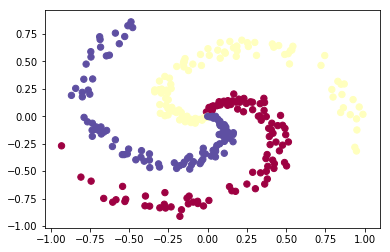

In [62]:
def get_data():
    N = 100 # number of points per class
    D = 2 # dimensionality
    K = 3 # number of classes
    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in range(K):
      ix = range(N*j,N*(j+1))
      r = np.linspace(0.0,1,N) # radius
      t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
      X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
      y[ix] = j
    return X, y
    
x, y = get_data()
print(x.shape)
print(y.shape)
plt.scatter(x[:, 0], x[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()


In [16]:
Nsample = 300
Nfeature = 2
N0 = 10
Nclass = 3
reg = 1e-3

expected = y
inputs = x
weights = init_weights((Nfeature, N0, Nclass))

loss_ = calc_layers(inputs, expected, weights, reg)
print(loss_)


1.0986264118045523
